# Import Data:

In [1]:
#list the data - the csv files in this directory are a result of the API code below
!mkdir Data
!ls Data

mkdir: cannot create directory ‘Data’: File exists
averages.csv  fivethirtyeight_partisan_lean_DISTRICTS.csv  Output
Cache	      fivethirtyeight_partisan_lean_STATES.csv	   vote_predictions.csv


In [2]:
!ls

Capstone Project Proposal - 2.pdf  images
Data				   PROPUBLICA_API_KEY.TXT
Exploratory Data Analysis.ipynb    README.md


### Get Pro Publica API working

In [3]:
import requests

#Load ProPublica API key without exposing it to github. Request one yourself. They're free.
#https://projects.propublica.org/api-docs/congress-api/
APIfile = open('./PROPUBLICA_API_KEY.TXT',)
APIkey = APIfile.read().replace('\n', '')

#simple unit tests - will throw an error if API key is malformed
assert type(APIkey) == str
assert len(APIkey) == 40

#create API key header
headers = {'X-API-Key': APIkey}

#API request function
def API_Request(end_point, verbose=True):
    '''for a given endpoint, return API response from Propublica api as a dictionary'''
    
    #send request using combined url, endpoint, and headers
    response = requests.get(url+end_point, headers=headers)
    
    #raise error if status code isn't 200. 
    response.raise_for_status()
    
    #return json response interpreted as a dictionary. 
    return response.json()

#load base url and test endpoint
url = 'https://api.propublica.org/congress/v1'
test_endpoint = '/members/new.json'

#test that the API is working. Prints 'OK' on succes
new_members = API_Request(test_endpoint)
assert new_members['status'] == 'OK'
assert new_members['results'][0]['num_results'] == '20'
print(new_members['status'])

OK


### OK, The API is working.  Let's import voting data

In [16]:
import pandas as pd
import numpy as np
from retrying import retry
from datetime import datetime
import sys


@retry(stop_max_attempt_number=5) #we're going to try this function 5 times until it returns a value
def API_attempts(endpoint):
    '''takes and endpoint and requests the API with it for a given number of times'''  
    #if we can't extract the status we'll keep trying, and if it's OK return the repsonse
    
    #initialize status as an error, this will change if we can extract it.
    status = 'Error fetching API response'
    
    #try to get the API response and extract status without throwing an error on failure
    try:
        #send endpoint to API function for request
        response = API_Request(endpoint)
        
        #extract the status of the API request
        status = response['status']   
    except:
        pass
    
    #if the status is not OK:
    if status != 'OK':
        #Say what the status is
        print(status, end=' ')
        
        #state that we're retrying
        print('retrying')
        
        raise
    else: 
        #return the response if status is ok
        return response
    
        
#let's create a function that will import vote positions for a given rollcall vote.
def import_vote(congress, chamber, session, roll_call):
    '''imports vote details and member positions of a given roll_call vote
        takes congress number 102-116 for House, 80-116 for Senate
        chamber(house|senate) session 1 for odd 2 for even-numbered years
        returns a dictionary of vote positions and API status'''
    #construct endpoint for API request
    for x in [congress, chamber, session, roll_call]:
        x = str(x)#                 
    call_endpoint = '/{}/{}/sessions/{}/votes/{}.json'.format(congress, chamber.lower(), session, roll_call)
    
    #let's attempt a few times to account for internet burps
    call_response = API_attempts(call_endpoint)
        
    #try to extract and return the vote positions
    try:
        vote = call_response['results']['votes']['vote']
        return vote
    except:
        return {}
    
def import_members(congress, chamber):
    '''imports memberdetails for a given congress and chamber
    https://projects.propublica.org/api-docs/congress-api/members/#lists-of-members'''
    
    #construct endpoint for API request
    for x in [congress, chamber]:
        x = str(x)#                 
    call_endpoint = '/{}/{}/members.json'.format(congress, chamber.lower())
    
    #let's attempt a few times to account for internet burps
    call_response = API_attempts(call_endpoint)
        
    #try to extract and return robustly
    try:
        members = call_response['results'][0]['members']
        return members
    except:
        return {}

def get_member(member_id):
    '''gets info on a specific member by member id 
    https://projects.propublica.org/api-docs/congress-api/members/#get-a-specific-member'''
    #construct API endpoint
    call_endpoint = '/members/{}.json'.format(member_id)
    
    #request API endpoint - retry a few times if needed
    call_response = API_attempts(call_endpoint)
    
       #try to extract results and return robustly
    try:
        member = call_response['results'][0]
        return member
    except:
        return {}
    
    
def positions_df(metalist):
    '''return a dataframe of postions for a given list of vote metadata'''
    
    #initialize dataframe
    dfp = pd.DataFrame()
    
    #for every position in the list
    for congress, chamber, session, roll_call in metalist:
        
        #request the roll_call vote from the API
        vote = import_vote(congress, chamber, session, roll_call)
        
        #extract the positions from the rollcall vote data
        positions = vote.pop('positions')
        
        #turn the postions into a dataframe
        call_positions = pd.DataFrame(positions)
        
        #if both dataframes we are going to merge are not empty
        if not dfp.empty and not call_positions.empty:
            
            #handle duplicated positions for malformed returns
            dups = call_positions.duplicated()
            if dups: 
                call_postions = call_positions.drop_duplicates()
                print('dropped{}duplicates'.format(dups.sum()))
        
            #MERGE THE POSITIONS FOR A GIVEN ROLL CALL VOTE INTO DATAFRAME <- core of function 
            dfp = pd.merge(dfp, call_positions, on=mergelst, how='outer')
            
            #let us know it's working
            print('.', end='')
            
        #If dfp is empty this is the first run and we need to initialize it
        elif dfp.empty: 
            #make it equal to call_positions
            dfp = call_positions
            
            #make a list of the columns that will be used to merge the call positions
            mergelst = dfp.columns.tolist()[:-1]
            
            #move party and state to front of merglist
            for x in ['state','party']:
                mergelst.insert(0, mergelst.pop(mergelst.index(x)))
            
            #alert that we've started
            print('\ndf created on', congress, chamber, session, roll_call, end=' ')
        
        #handle empty postitions dataframe:
        elif call_positions.empty:
            
            #let us know there was a problem
            print('\nno vote postions available for', congress, chamber, session, roll_call, end=' ')
            
            #append a series of Nan values
            ht = dfp.shape[0]
            nans = pd.Series([np.nan for _ in range(ht)])
            print ('dfp.shape:', dfp.shape)
            print ('Appending {} NaNs'.format(len(nans)))
            dfp = pd.concat([dfp, nans], axis = 1)
            print(dfp.iloc[:3,-4:])
        
        #handle unknown issue
        else:
            print('\nunknown error for', congress, chamber, session, roll_call, end=' ')
    
    #create a multindex of partymembers
    dfp = dfp.set_index(mergelst).transpose()
    
    #after transposing use the metalist as the index
    dfp.index = metalist
    
    #return the complete data frame
    return dfp 

def import_month(year, chamber, month):
    '''import vote metadata for a given year or month and return a dataframe '''
    
    #Stop everthing if we are using a year before 1989 or after now
    assert 1989 <= year <= int(datetime.now().year), "year out of range"
    
    #construct endpoint
    call_endpoint = '/{}/votes/{}/{}.json'.format(chamber.lower(), str(year), str(month))
    
    #use endpoint to request the API robustly with attempts function
    response = API_attempts(call_endpoint)
    
    #Extract the votes from the response
    votes = response['results']['votes']

    #create a dataframe out of the votes
    votesdf = pd.DataFrame(votes)
    
    if not votesdf.empty:
        votesdf = votesdf.set_index(['congress','chamber','session','roll_call']).sort_index()
    
    #return the months dataframe
    return votesdf

def import_year(year, chamber):
    '''import votes based on dates, return a dataframe of appended votes'''
    
    
    #So we know we started:
    print('importing', chamber, year, end=' ')
    #loop through the months 
    for month in range(1,13):
        
        #import the first month
        if month == 1:
            yeardf = import_month(year, chamber, month)
       
        #import the month of votes as a df and append it to the list 
        else:
            df = import_month(year, chamber, month)
            if not df.empty:
                yeardf = yeardf.append(df)
            else:
                print('skip', end=' ')
        #print something so we know it's working
        print(month, end=' ')
        
    #return the dataframe
    return yeardf

def save_years(start_y, end_y):
    '''take a range of years and save a series of dataframes for those years in both the hosue and senate'''
    #iterate through the range of years
    for year in range(start_y, end_y+1):
        #alternate between senate and house
        for chamber in ['senate','house']:
            
            #construct paths
            metapath, pospath = construct_paths(year, chamber)
            
            #import vote metadata dataframe
            votemetadf = import_year(year, chamber)
            
            #import vote positions for given dataframe
            voteposdf = positions_df(votemetadf.index)
            
            #save them
            save_csv(year, chamber, votemetadf, metapath)
            save_csv(year, chamber, voteposdf, pospath)
            
def save_csv(year, chamber, df, path):
    '''takes dataframes from a given year and chamber and saves them to given paths'''
    #announce what we're doing
    print('\nsaving {} {} as {}'.format(str(year), chamber, path))
        
    #save data frames as csv in data/csv directory
    df.to_csv(path)
    
def construct_paths(year, chamber):
    '''construct paths to save or load csv files, 
    takes year and chamber and returns meta path and position path'''
    pathhead = 'Data/Cache/{}_{}vote_'.format(str(year), chamber)
    metapath = pathhead + 'meta.csv'
    pospath = pathhead + 'pos.csv'
    return metapath, pospath

def get_delta(votemetadf, voteposdf):
    '''check for differences in index, import missing and save new file if found'''
    
        
    return voteposdf
                    
def load_cache(year, chamber, force=False):
    '''try to load data for a given year and chamber from csv, and use the API to cache it if it's missing'''
    
    #construct paths
    metapath, pospath = construct_paths(year, chamber.lower())
    
    #setup header / index col
    header = list(range(5))
    if chamber.lower() == 'house':
        header.append(5)
    index_col = list(range(4))
    
    #try to import to load the dfs via csv, and if they don't exist import via the API and cache them.
    try:
        assert force == False,'Force'
        votemetadf = pd.read_csv(metapath, index_col=index_col)
        #check if too many days have passed 
        if year == int(datetime.now().year):
            assert (datetime.now() - pd.to_datetime(votemetadf.date)[-1]).days < 7, 'Cache out of date'            
        
    except (FileNotFoundError, AssertionError, KeyError) as e:
        print(e, 'importing from API')
        votemetadf = import_year(year, chamber)
        save_csv(year, chamber, votemetadf, metapath)
        
    try:
        #Skip strait to manual import if force is on 
        assert force == False,'Force' 
        
        #import df from csv
        voteposdf = pd.read_csv(pospath, header=header, index_col=index_col, engine='python')
        
        #covert columns to floats - work around for pd.read_csv issue #9435:
        
        floatcol = voteposdf.columns.levels[-3].astype(float) #<-issue is columns are tuples instead of multi-index
        #print(floatcol)#.loc[:,'dw_nominate'].astype(float)
        newcolumns = voteposdf.columns.set_levels(floatcol, level='dw_nominate')
        voteposdf.columns = newcolumns
        
        #check for a difference in indexes, if there is one import the delta.
        deltaidx = set(votemetadf.index.tolist()) - set(voteposdf.index.tolist())
        if deltaidx:        
            print('Missing data, importing delta')
            delta = positions_df(deltaidx)
            voteposdf = pd.concat([voteposdf, delta], sort=False)
            voteposdf = voteposdf.loc[:,~voteposdf.columns.duplicated()]
            voteposdf.sort_index('index', inplace=True)
            save_csv(year, chamber, voteposdf, pospath)
            
    except (FileNotFoundError, AssertionError) as e:
        print(e, 'importing from API', end = '')
        #force complete import from API and cache
        voteposdf = positions_df(votemetadf.index)
        save_csv(year, chamber, voteposdf, pospath)
    
    #if call function recursively with force on
    except (AttributeError, ValueError) as e:
        print(e, 'trying again with API force')
        votemetadf, voteposdf = load_cache(year, chamber, force=True)
    
    return votemetadf, voteposdf
   
    
#tests - comment out when working

#senate_month_test = import_month(2019, 'senate', 1)
#senate_month_test

#senate_2019_test = import_year(2019, 'senate')
#senate_2019_test

#positions = positions_df(senate_2019_test.index)
#positions

#save_years(2019, 2019)

testmetahouse, test_dfhouse = load_cache(2019, 'house')
test_dfhouse.head()
#members = import_members(115, 'senate')
#print(len(members))

#member = get_member('W000817')
#print(member['first_name'], member['last_name'])

party                                         D                 \
state                                        AL             AZ   
district                                      7              1   
dw_nominate                              -0.391         -0.173   
member_id                               S001185        O000171   
name                               Terri Sewell Tom O'Halleran   
congress chamber session roll_call                               
116      House   1       1              Present        Present   
                         2               Pelosi         Pelosi   
                         3                  Yes            Yes   
                         4                  Yes            Yes   
                         5           Not Voting             No   

party                                                                \
state                                                                 
district                                         2                3   
dw_nominate                                 -0.159           -0.599   
member_id                                  K000368          G000551   
name                               Ann Kirkpatrick Raúl M. Grijalva   
congress chamber session roll_call                                    
116      House   1       1                 Present          Present   
                         2                  Pelosi           Pelosi   
                         3                     Yes              Yes   
                         4                     Yes              Yes   
                         5                      No               No   

party                                                                      \
state                                                                  CA   
district                                       7            9          10   
dw_nominate                               -0.453          NaN         NaN   
member_id                                G000574      S001211     H001090   
name                               Ruben Gallego Greg Stanton Josh Harder   
congress chamber session roll_call                                          
116      House   1       1               Present      Present     Present   
                         2                Pelosi       Pelosi      Pelosi   
                         3                   Yes          Yes         Yes   
                         4                   Yes          Yes         Yes   
                         5                    No           No          No   

party                                                                        \
state                                                                         
district                                        11           12          13   
dw_nominate                                 -0.532       -0.490      -0.683   
member_id                                  D000623      P000197     L000551   
name                               Mark DeSaulnier Nancy Pelosi Barbara Lee   
congress chamber session roll_call                                            
116      House   1       1                 Present      Present     Present   
                         2                  Pelosi       Pelosi      Pelosi   
                         3                     Yes      Speaker         Yes   
                         4                     Yes      Speaker         Yes   
                         5                      No      Speaker          No   

party                               ...                      R              \
state                               ...                     WA          WI   
district                            ...                      5           1   
dw_nominate                         ...                  0.429         NaN   
member_id                           ...                M001159     S001213   
name                                ... Cathy McMorris Rodgers Bryan Steil   
congress cha

# Explore Data:

## Sort by political spectrum
Political scientists have already provided a metric for political ideology using dimension reduction called [dw_nominate](https://voteview.com/about). In the 1st dimension, scores closer to 1 indicate conservative voting behavior while scores closer to -1 indicate liberal voting behavior. Sorting by this indicator easily distinguishes parties from one another in the multi-index of house members.

In [17]:
from tabulate import tabulate
testmetasenate, test_dfsenate = load_cache(2019, 'Senate')
test_dfsenate.sort_index('columns', level='dw_nominate', inplace=True)
test_dfsenate.head()
#print(tabulate(testmetasenate[:1], tablefmt='github', showindex=True, headers='keys')) #for markdown

party                                             D                            \
state                                            MA            CA          NJ   
dw_nominate                                  -0.767        -0.696      -0.620   
member_id                                   W000817       H001075     B001288   
name                               Elizabeth Warren Kamala Harris Cory Booker   
congress chamber session roll_call                                              
116      Senate  1       1                       No            No          No   
                         2                       No            No          No   
                         3                       No            No          No   
                         4                       No            No          No   
                         5                      Yes           Yes         Yes   

party                                           ID             D  \
state                                           VT            WI   
dw_nominate                                 -0.524        -0.518   
member_id                                  S000033       B001230   
name                               Bernard Sanders Tammy Baldwin   
congress chamber session roll_call                                 
116      Senate  1       1                      No            No   
                         2                      No            No   
                         3                      No            No   
                         4                      No            No   
                         5                     Yes           Yes   

party                                                                \
state                                            MA              HI   
dw_nominate                                  -0.505          -0.492   
member_id                                   M000133         H001042   
name                               Edward J. Markey Mazie K. Hirono   
congress chamber session roll_call                                    
116      Senate  1       1                       No              No   
                         2                       No              No   
                         3                       No              No   
                         4                       No              No   
                         5                      Yes             Yes   

party                                                                    ...  \
state                                        OR        NM            OH  ...   
dw_nominate                              -0.475    -0.456        -0.435  ...   
member_id                               M001176   U000039       B000944  ...   
name                               Jeff Merkley Tom Udall Sherrod Brown  ...   
congress chamber session roll_call                                       ...   
116      Senate  1       1                   No        No            No  ...   
                         2                   No        No            No  ...   
                         3                   No        No            No  ...   
                         4                   No        No            No  ...   
                         5                  Yes       Yes           Yes  ...   

party                                      R                              \
state                                     SC                PA        NE   
dw_nominate                            0.642             0.644     0.809   
member_id                            S001184           T000461   S001197   
name                               Tim Scott Patrick J. Toomey Ben Sasse   
congress chamber session roll_call                                         
116      Senate  1       1               Yes               Yes       Yes   
                         2               Yes               Yes       Yes   
                         3               Yes               Yes       Yes   
            

In [18]:
#Print a table into github flavored markdown
#print(tabulate(test_dfsenate.head(), tablefmt='github', showindex=True, headers='keys')) #for markdown
#test_dfsenate.head()

## What patterns are apparent in the data?

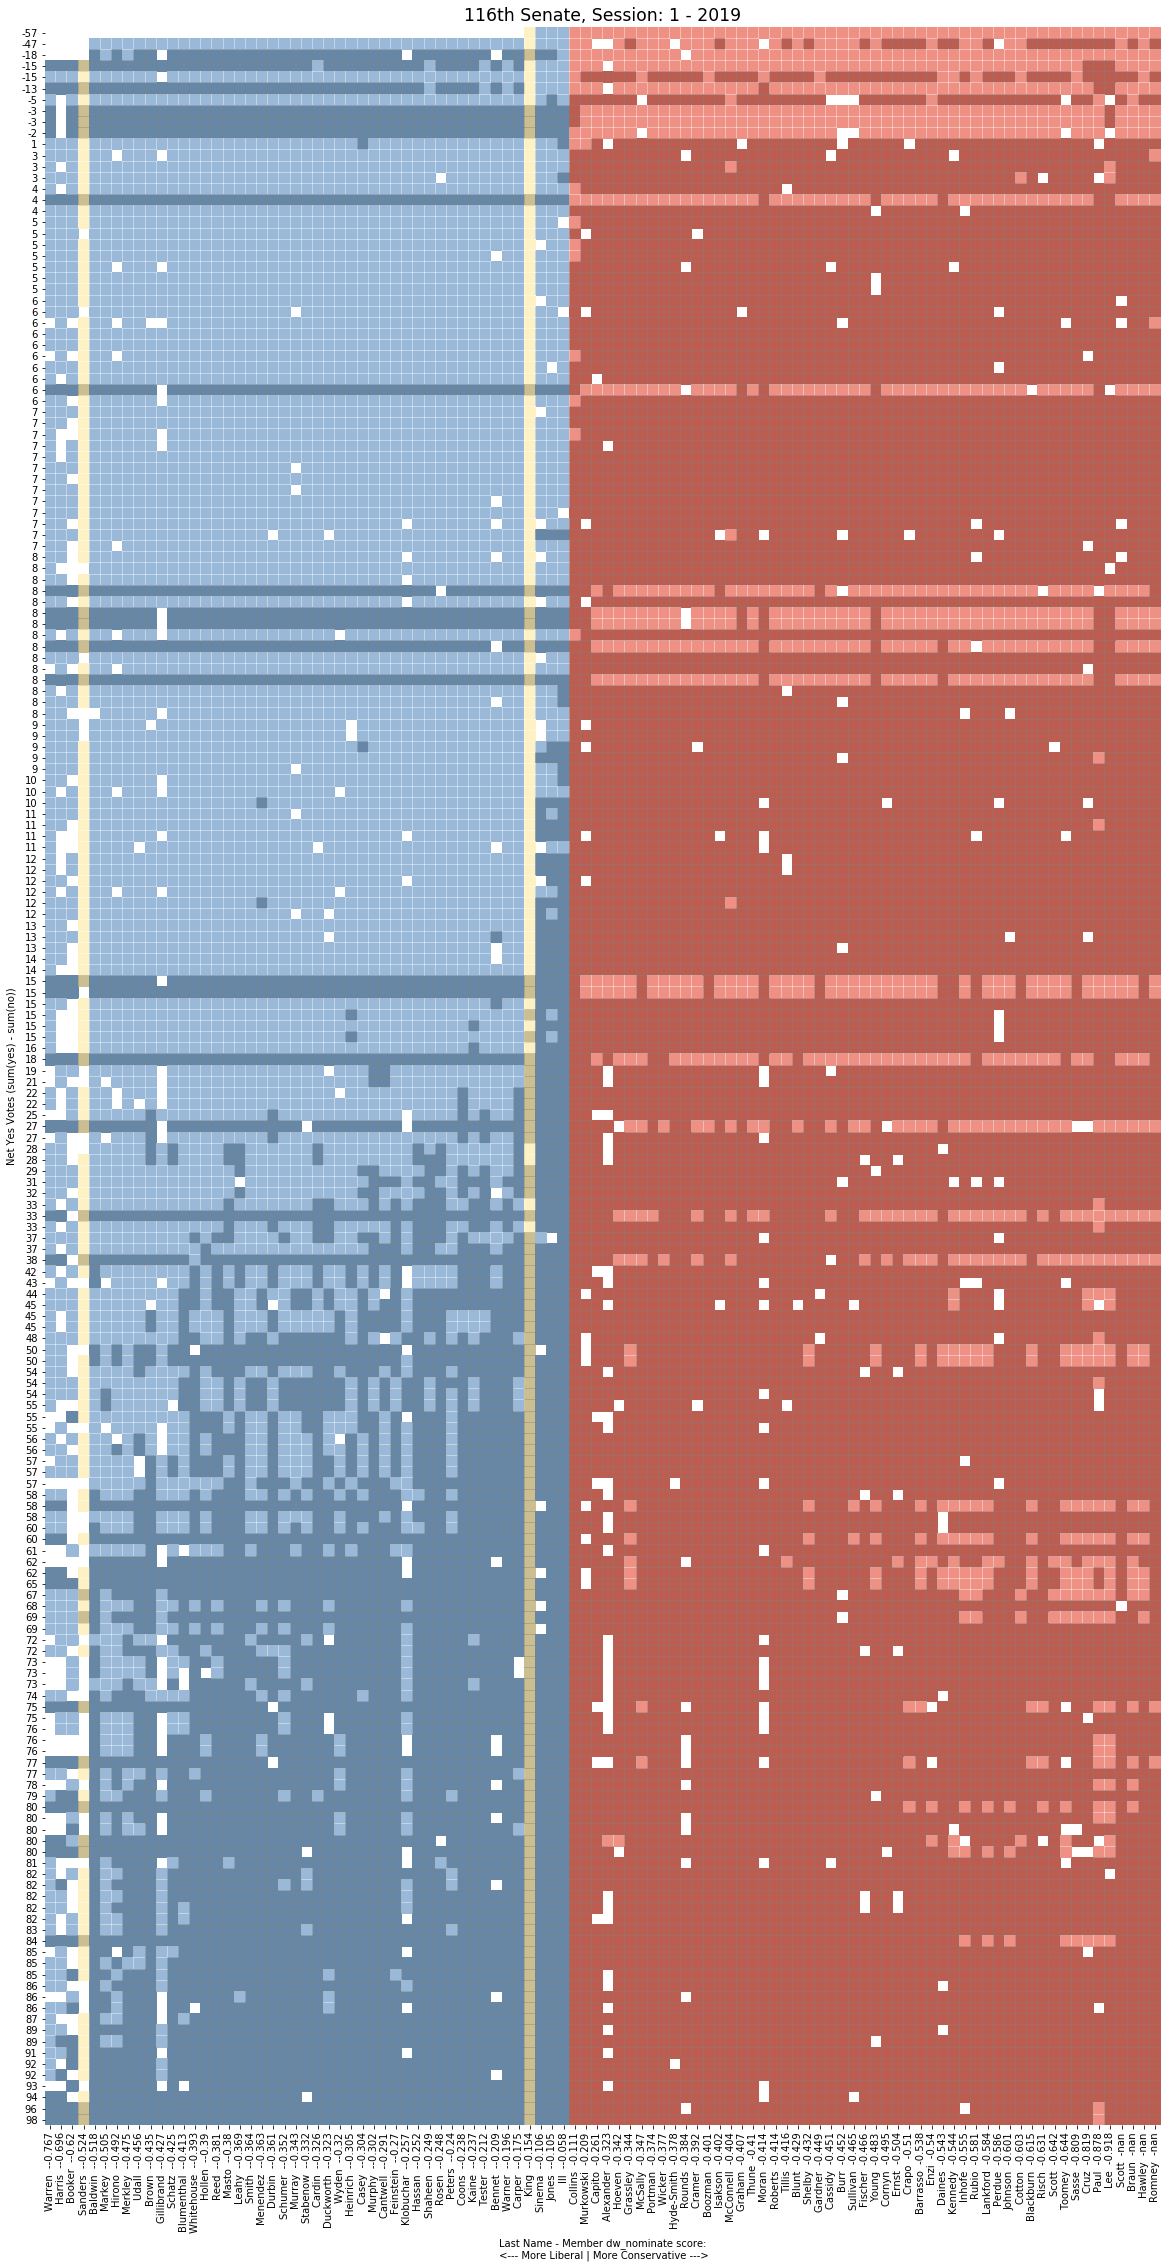

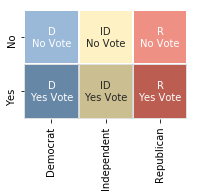

In [19]:
#Visualize a session
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

def visualize_session(year, chamber):
    
    #Past versions of pandas have an error that prevents multiindex sorting with floats.
    assert int(''.join(pd.__version__.split('.'))) >= 242, 'Pandas should be version 0.24.2 or above'
    
    #load dataframe from csv or API
    _, df = load_cache(year, chamber)

    #set up a default dict that will return 1 if 'Yes,' -1 if 'No,' and 0 if anything else, while adding keys.
    factordict = defaultdict(int)
    factordict['Yes'], factordict['No'] = 1,-1

    #prep data (sort by party / dw_nominate score, then code yes / no into votes into negative positive values)
    data = df.applymap(lambda x: factordict[x]).sort_index('columns', 'dw_nominate')
    
    #sort by dw_nominate. (sort_index) doesn't work with floats... so.

    
    #sort votes by net votes
    sortseries = data.sum(axis=1)
    sortseries.sort_values(inplace=True)
    data = data.reindex(sortseries.index)
    mask = data.applymap(lambda x: x == 0).values

    #create a dataframe to map red and blue colors
    partydict = defaultdict(int)
    partydict['R'], partydict['D'] = 1, -1
    colormask = data.apply(lambda x: x.index.get_level_values(0).astype(str), axis=1, result_type='expand')
    colormask = colormask.applymap(lambda x: partydict[x])
    

    #change index's to something useful
    data.index = sortseries.values
    data.index.name = 'Net Yes Votes (sum(yes) - sum(no))'
    #newcol = data.columns.droplevel([level for level in data.columns.names if not level in ['dw_nominate', 'name']])    
    dw = data.columns.get_level_values('dw_nominate')
    lastnames = data.columns.get_level_values('name').map(lambda x: x.split(" ")[-1]+'  ')
    #print(lastnames)
    data.columns = pd.MultiIndex.from_arrays([lastnames, dw], names=('Last Name ',' Member dw_nominate score:\n <--- More Liberal | More Conservative --->'))
    #data.columns.name = 
    
    #setup scale
    base=10
    scale=1
    wd = 20
    ht = int(len(data.index)/scale+base)
    #print(wd, ht)
    f, ax = plt.subplots(1,1, figsize=(wd,ht))

    sns.set_palette('muted')

    #plot the party colors
    cmap = sns.color_palette('RdYlBu_r')
    sns.heatmap(data=colormask, ax=ax, cmap=cmap, linewidth=0, alpha=1, mask=mask, cbar=False, square=True)
    #cbar=True, cbar_kws = dict(use_gridspec=False, location='bottom'))

    #plot the yes no vote data
    cmap1 = ['white','grey']
    sns.heatmap(data=data, ax=ax, cmap=cmap1, linewidth=0, cbar=False, alpha=.4, mask=mask)
    
    #set up title (will need to modify to vizualize more than one session)
    titleitems = tuple(df.index.droplevel(3).tolist()[0])
    titlestring = '{}th {}, Session: {} - {}'.format(*titleitems,year)
    ax.set_title(titlestring, fontsize='xx-large')

    #display the "legend"
    display_key(cmap, cmap1)
    
    #display the p
    plt.show()

def display_key(cmap, cmap1):
    #Create the key
    f, ax1 = plt.subplots(1, figsize=(3, 2))

    labels = np.array([['D\nNo Vote','ID\nNo Vote','R\nNo Vote'],\
                   ['D\nYes Vote','ID\nYes Vote','R\nYes Vote']])

    xticklabels=['Democrat','Independent','Republican']
    yticklabels=['No','Yes']

    sns.heatmap(data=[[-1,0,1],[-1,0,1]], ax=ax1, cmap=cmap, linewidth=1, cbar=False, alpha=1, annot=labels, fmt='', square=True)
    sns.heatmap(data=[[-1,-1,-1],[1,1,1]], ax=ax1, cmap=cmap1, linewidth=1, cbar=False, alpha=.4, xticklabels=xticklabels, yticklabels=yticklabels)

    #show the plot

visualize_session(2019, 'Senate')


The plot above can be used to visualize all the votes in a given session, sorted by how many net votes they received, and the, and how liberal/conservative members are according to their dw_nominate score. 

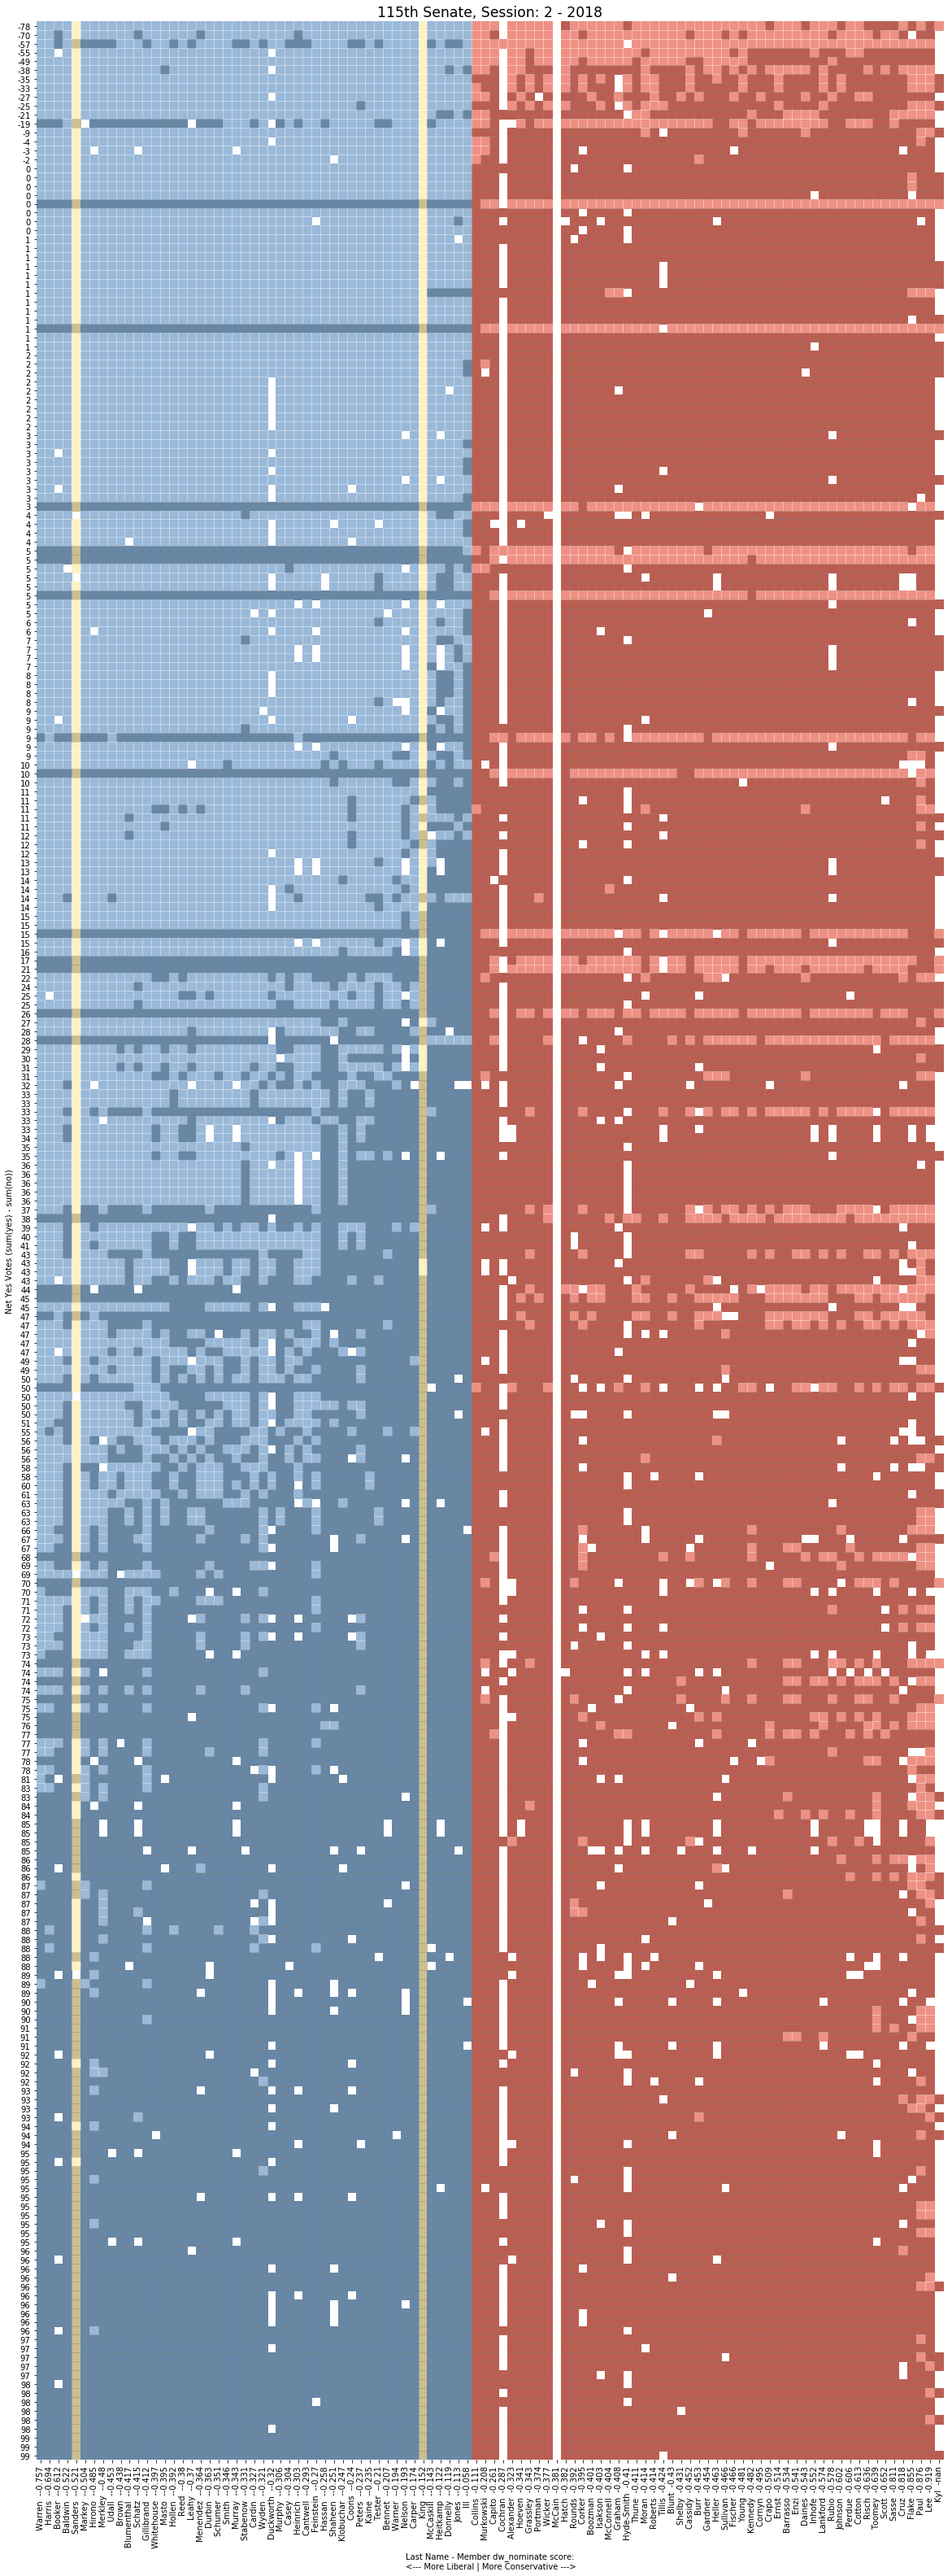

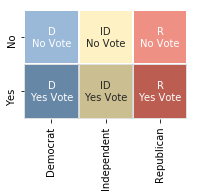

In [20]:
visualize_session(2018, 'Senate')

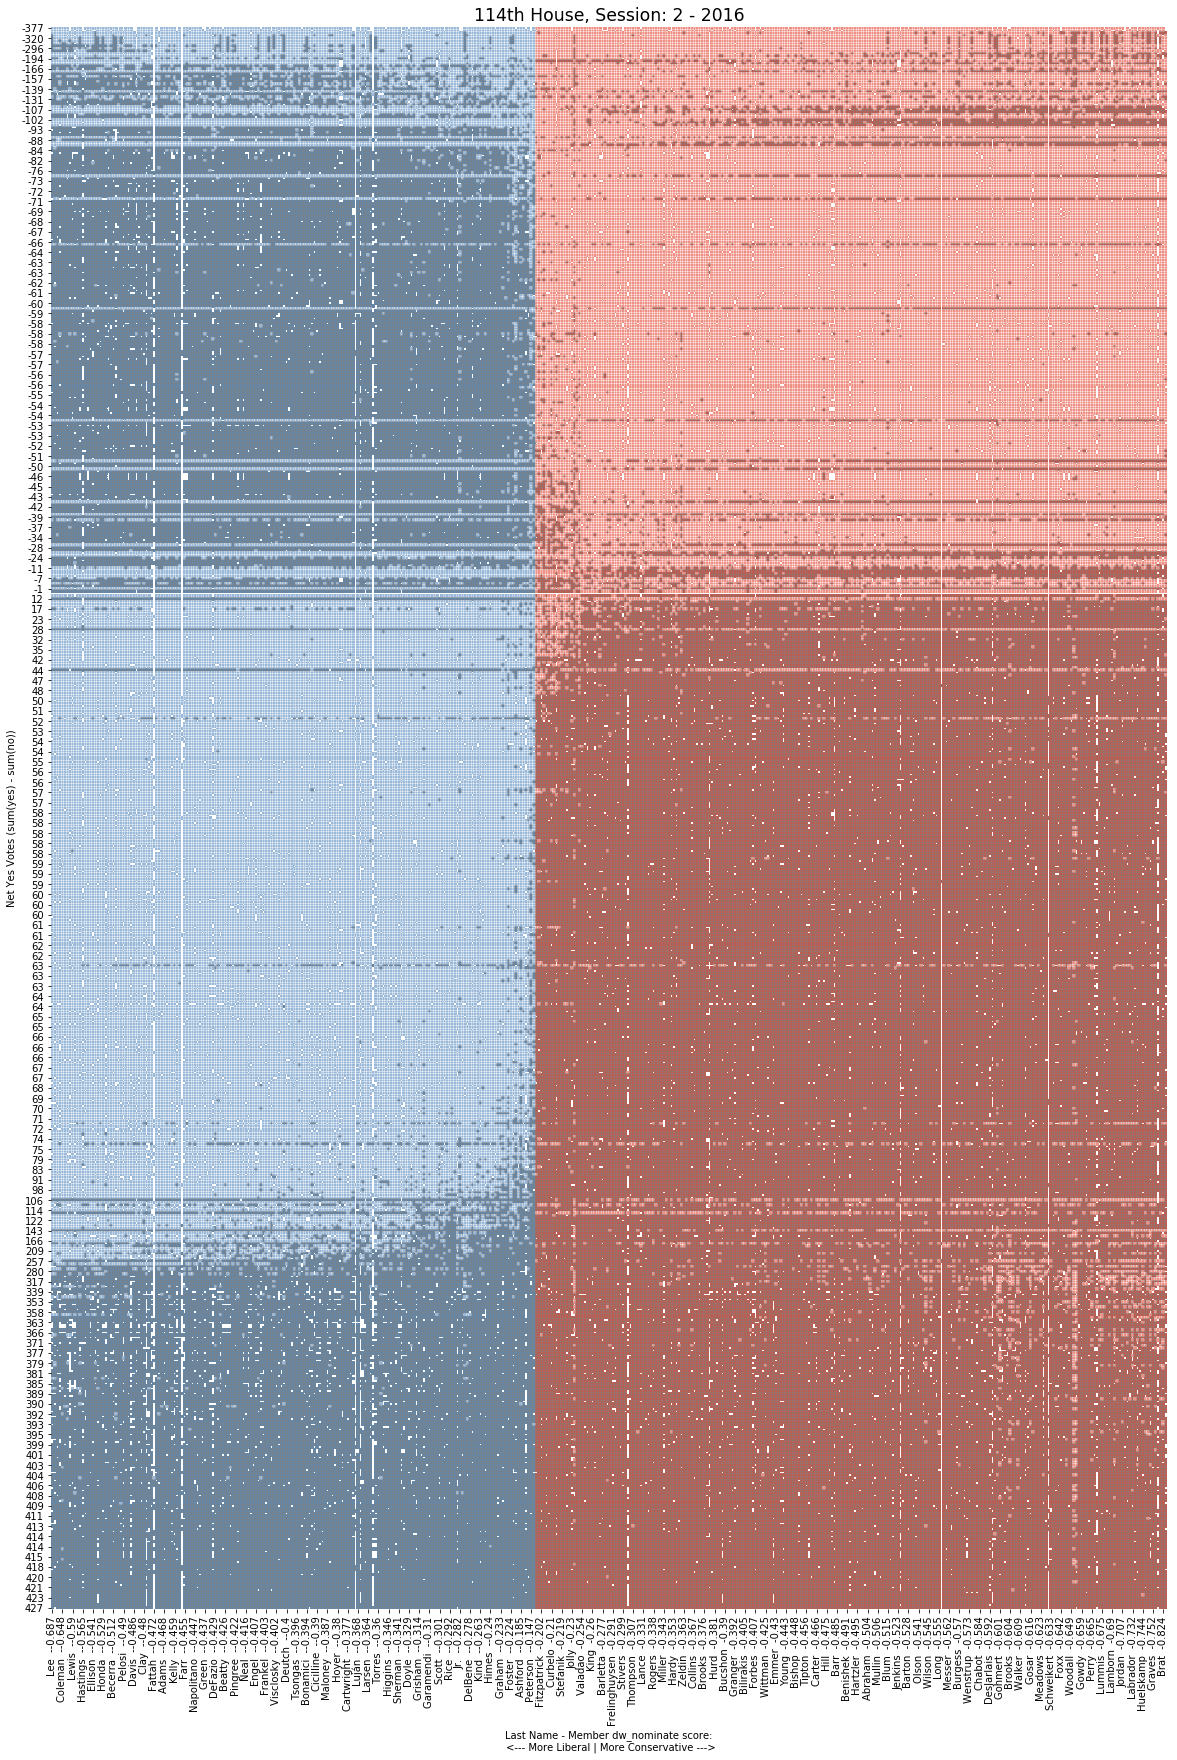

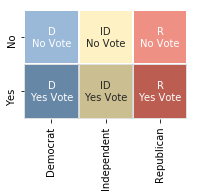

In [21]:
visualize_session(2016, 'house')

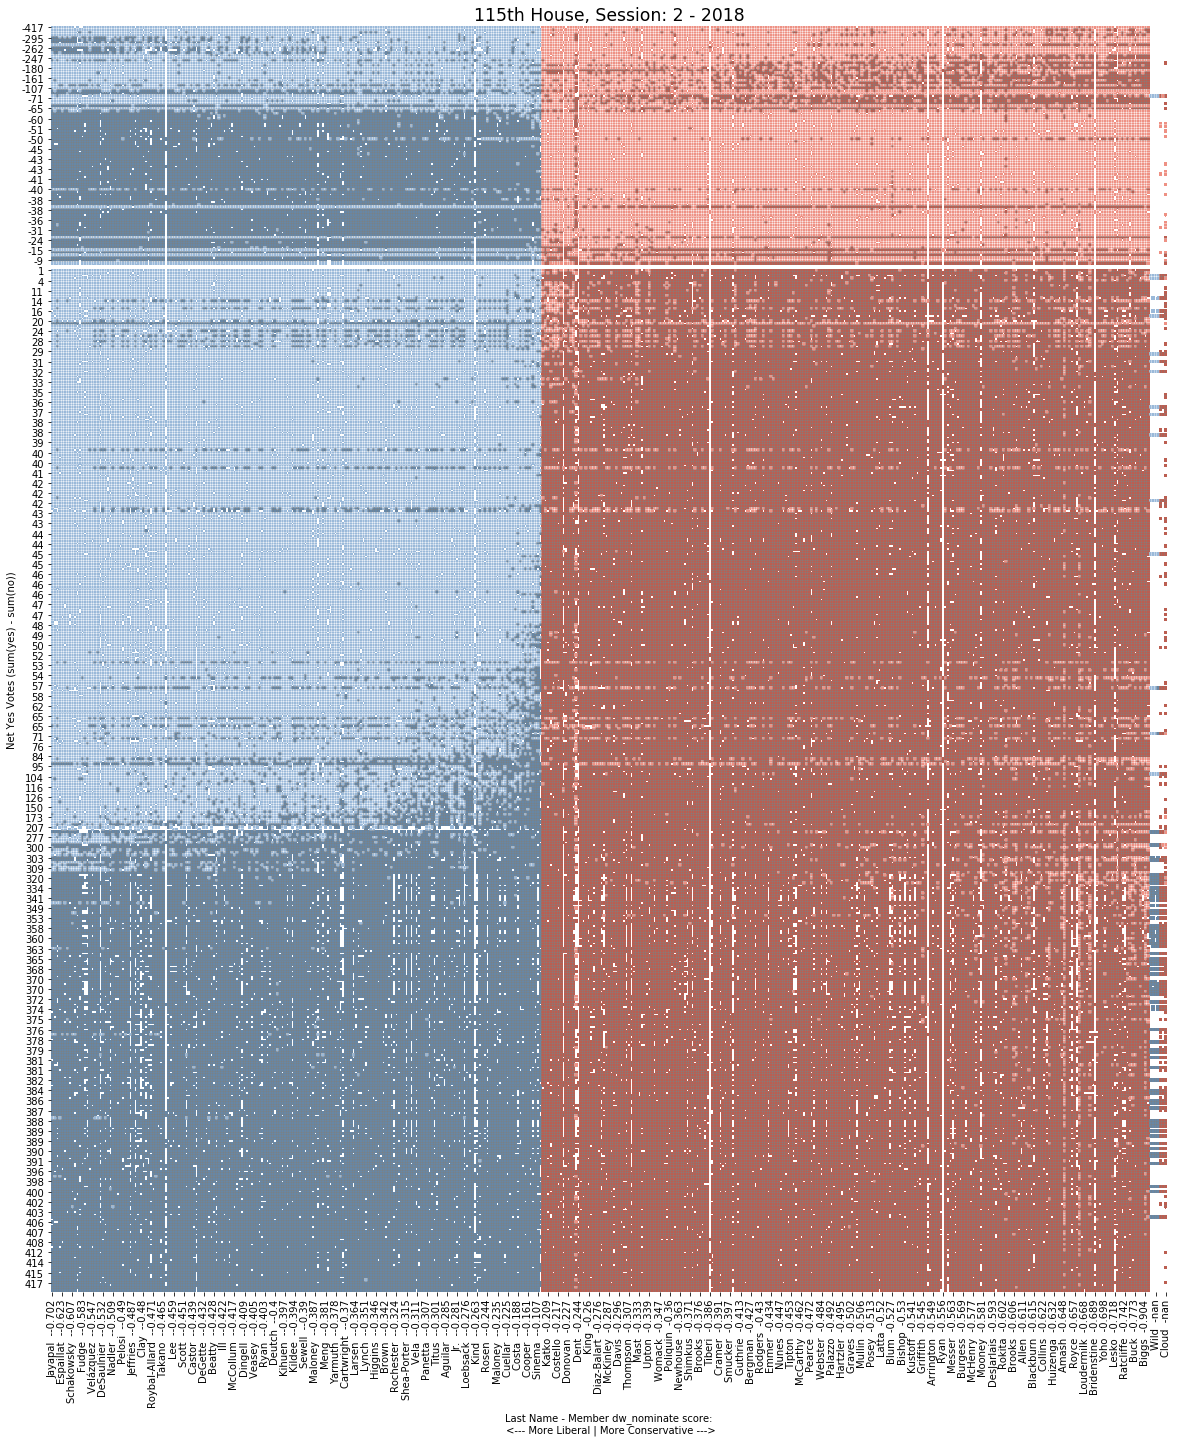

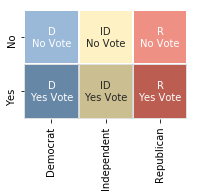

In [22]:
visualize_session(2018, 'House')

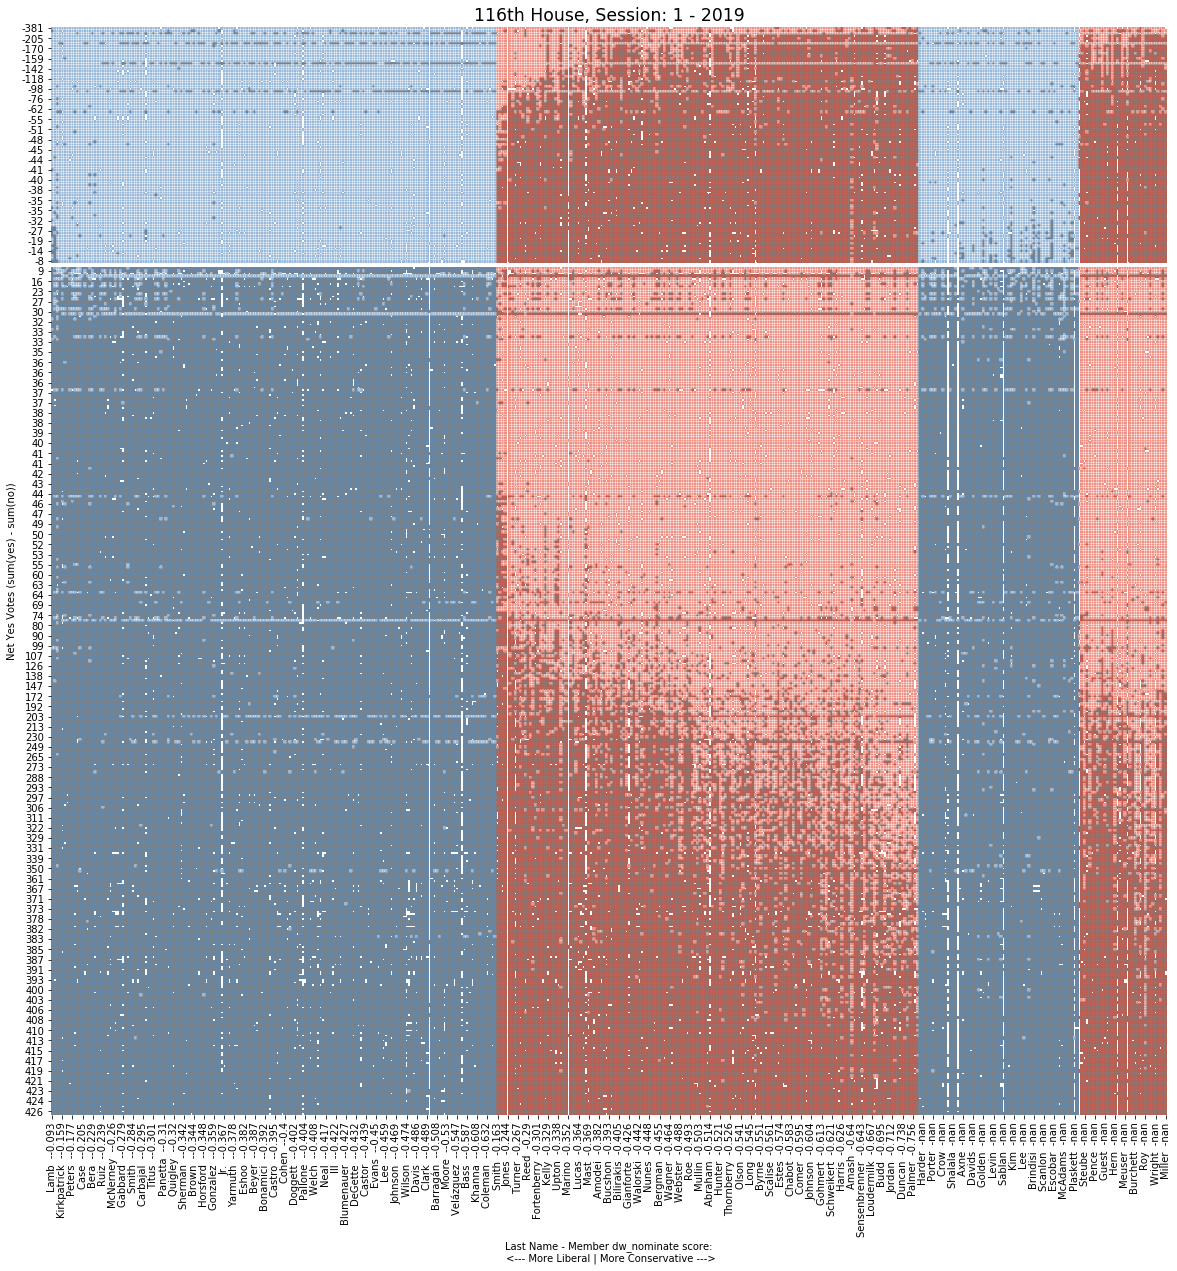

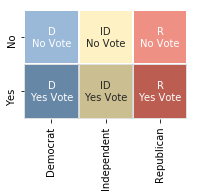

In [23]:
visualize_session(2019, 'house')

## Which members tend to survive?

In [24]:
meta, pos = load_cache(2019, 'Senate')
pos.columns.names

FrozenList(['party', 'state', 'dw_nominate', 'member_id', 'name'])

In [25]:
#Create list of longest surviving candidates - query api directly

#get a list of memebers for a (doesn't include start end years)
#for date in range(2010,2019,2):
#    meta, pos = load_cache(date, 'Senate')
#    print(meta.index[0])
#    congress, chamber = meta.index[0][:2]
#    print(congress, chamber)
#    members = import_members(congress, chamber)
#    print(members[0])
#    for member in members:
#        print(member['last_name'])

#create a df (set? dictionary?) of senators with their first start and last end date. 
#initialize dictionary
def all_members(chamber):
    'get all members for a range of years'
    
    #initialize a dictionary
    membersdict = {}
    
    #for 20 years of dates
    for date in range(int(datetime.now().year),1998, -1):
        
        print('\nReqesting', date, chamber, end='')
        
        #load the meta and postions dataframes saved for that date
        meta, pos = load_cache(date, chamber)
        
        #extract the index.
        multi_index = pos.columns
    
        #loop through every item in the index
        for item in multi_index:
            
            #make a dictionary out of the index items and names
            indexdict = dict(zip(pos.columns.names, item))
            
            #extract the member_id from the index
            member_id = indexdict['member_id']
            
            #if the member id isn't in the dictionary already:
            if member_id not in membersdict.keys():
                
                #request the member info from the API
                m = get_member(member_id)
                
                #get a list of all the roles that member has had
                r = m['roles']
                
                #initialize a dictionary of that member's info
                mdict = {}
                
                #add info from the following list of keys to the dictionary
                for key in ['first_name', 'middle_name','last_name','current_party','in_office']:
                    mdict[key] = m[key]
                
                #add the start date of their first role and the end date of their last role -
                #NEED TO SEE IF THIS IS ALL IN THE SAME CHAMBER.
                #iterate through if the chamber matches, pick the last end date. 
                for roll in r:
                    if roll['chamber'].lower() == chamber:
                        mdict['end_date'] = roll['end_date']
                        break
                for roll in r:
                    if roll['chamber'].lower() == chamber:
                        mdict['start_date'] = roll['start_date']
                
                dw_nominate = indexdict.pop('dw_nominate')
                
                if dw_nominate != np.NaN: 
                    mdict['dw_nominate'] = dw_nominate
                
                #add info from the index dictionary
                mdict.update(indexdict) # some of these indicators change year to year... need to account
                
                #store that all in the main dictionary under the member_id - consider doing with items
                membersdict[member_id] = mdict
                #indicate we did something
                print('.', end='')
                
    #return the dictionary as a dataframe
    return pd.DataFrame(membersdict).transpose()

def load_members(chamber, force=False):
    chamber = chamber.lower()
    path = 'Data/Cache/memberinfo_{}.csv'.format(chamber)
    try:
        df = pd.read_csv(path)
        
        assert force == False, 'force'
    except (FileNotFoundError, AssertionError, KeyError) as e:
        print(e, 'importing from API')
        df = all_members(chamber)
        
        
        
        #save data frames as csv in data/csv directory
        print('saving as {}'.format(path))
        df.to_csv(path)
    
    #resolve years in office
    df.loc[:,'start_date'] = pd.to_datetime(df.loc[:,'start_date'])
    df.loc[:,'end_date'] = pd.to_datetime(df.loc[:,'end_date'])
    df['years_in_office'] = (df.loc[:,'end_date'] - df.loc[:,'start_date'])
    df.years_in_office = df.years_in_office.apply(lambda x: x.days / 365)
            
    return df

df = load_members('House', force=False)
df

,Unnamed: 0,current_party,district,dw_nominate,end_date,first_name,in_office,last_name,member_id,middle_name,name,party,start_date,state,years_in_office
0,A000374,R,5,0.514,2021-01-03,Ralph,True,Abraham,A000374,NaN,Ralph Abraham,R,2015-01-06,LA,5.997260
1,A000370,D,12,-0.469,2021-01-03,Alma,True,Adams,A000370,NaN,Alma Adams,D,2014-11-12,NC,6.147945
2,A000055,R,4,0.364,2021-01-03,Robert,True,Aderholt,A000055,B.,Robert B. Aderholt,R,1997-01-07,AL,24.005479
3,A000371,D,31,-0.287,2021-01-03,Pete,True,Aguilar,A000371,NaN,Pete Aguilar,D,2015-01-06,CA,5.997260
4,A000372,R,12,0.639,2021-01-03,Rick,True,Allen,A000372,NaN,Rick Allen,R,2015-01-06,GA,5.997260
5,A000376,D,32,NaN,2021-01-03,Colin,True,Allred,A000376,NaN,Colin Allred,D,2019-01-03,TX,2.002740
6,A000367,R,3,0.640,2021-01-03,Justin,True,Amash,A000367,NaN,Justin Amash,R,2011-01-04,MI,10.005479
7,A000369,R,2,0.382,2021-01-03,Mark,True,Amodei,A000369,NaN,Mark Amodei,R,2011-09-15,NV,9.309589
8,A000377,R,1,NaN,2021-01-03,Kelly,True,Armstrong,A000377,NaN,Kelly Armstrong,R,2019-01-03,ND,2.002740
9,A000375,R,19,0.522,2021-01-03,Jodey,True,Arrington,A000375,NaN,Jodey Arrington,R,2017-01-03,TX,4.002740


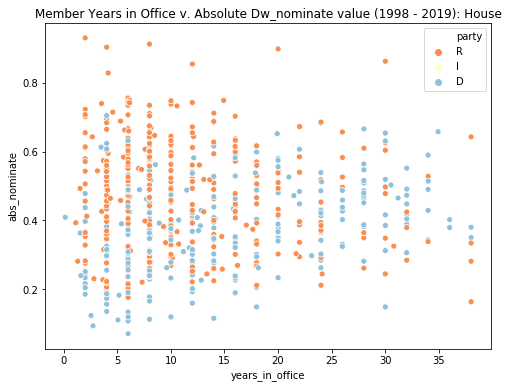

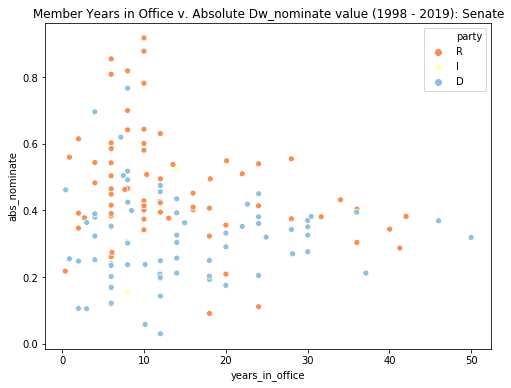

In [26]:
def years_nominate(df):

    #df.loc[:,'start_date'] = pd.to_datetime(df.loc[:,'start_date'])
    #df.loc[:,'end_date'] = pd.to_datetime(df.loc[:,'end_date'])
    #df['years_in_office'] = (df.loc[:,'end_date'] - df.loc[:,'start_date'])
    #df.years_in_office = df.years_in_office.apply(lambda x: x.days / 365)


    df['abs_nominate'] = abs(df['dw_nominate'])
    df.party = df.party.apply(lambda x: 'I' if x == 'ID' else x)
    f, ax, = plt.subplots(1,1, figsize=(8,6))
    palette = sns.color_palette('RdYlBu',3)
    sns.scatterplot('years_in_office','abs_nominate', hue='party', hue_order=['R','I','D'],
            data=df, ax=ax, palette=palette)
    return ax
    
housedf = load_members('House')
senatedf = load_members('Senate')

ax1 = years_nominate(housedf)
ax2 = years_nominate(senatedf)

titlestr = 'Member Years in Office v. Absolute Dw_nominate value (1998 - 2019): '
ax1.set_title(titlestr+'House')
ax2.set_title(titlestr+'Senate')

plt.show()

There appears to be a definitive trend, of longer lasting members being more toward the center of their respective side of the political spectrum.  In the Senate, dw_nominate scores appear to approach .37 distance from 0 as years in office increase. In the House, scores appear to converge toward .5 distance from 0 as years in office increase. It appears that there are more Republicans with extreme dw_nominate scores that last longer.



### Hypothesis: Members more in line with the party preferences of their district survive longer.

In [27]:
statelean = pd.read_csv('Data/fivethirtyeight_partisan_lean_STATES.csv')
distlean = pd.read_csv('Data/fivethirtyeight_partisan_lean_DISTRICTS.csv')

In [28]:
def process_lean(x):
    party, lean = x.split('+')
    lean = float(lean)/100
    if party == 'R':
        return lean
    if party == 'D':
        return -lean


statelean['lean'] = statelean.pvi_538.apply(process_lean)
#statelean

In [29]:
distlean['lean'] = distlean.pvi_538.apply(process_lean)
#distlean

In [30]:
distlean['state'] = distlean['district'].apply(lambda x: x.split('-')[0])
distlean['district'] = distlean['district'].apply(lambda x: int(x.split('-')[1]))

In [31]:

endafter = [x.year >= 2018 for x in df.end_date]
startbefore = [x.year <= 2018 for x in df.start_date]
house2018 = [all(x) for x in zip(endafter, startbefore)]
#house2018

In [32]:
data = pd.merge(df.loc[house2018], distlean, on=['state','district'], how='left')
ded2018 = [x.year == 2019 for x in data.end_date]
deddata = data.loc[ded2018]
#R = (data.party == 'R')
#Rsize = [int(x)*30 for x in R]
ded = [int(x)*30 for x in ded2018]

/home/nhorning/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


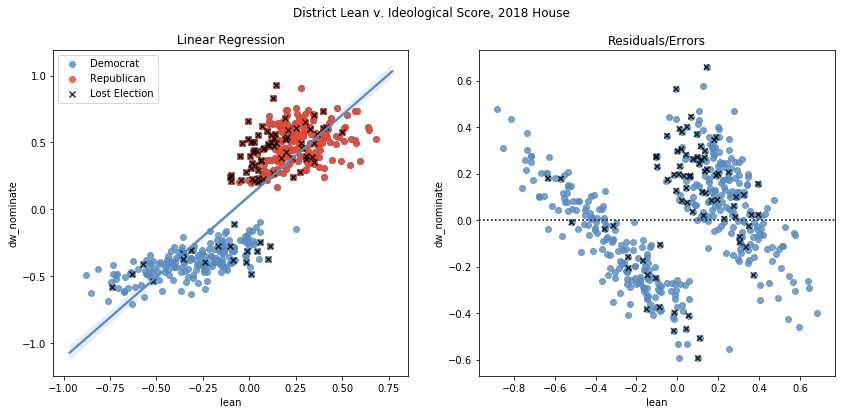

In [33]:

#relationship between district lean and dw_nominate

palette = sns.color_palette('RdYlBu',6)

R = [x == 'R' for x in data.party]
Rsize = [int(x)*30 for x in R]

f, (ax1, ax2) = plt.subplots(1,2, figsize=(14,6))
sns.regplot('lean','dw_nominate', data=data, ax=ax1, label='Democrat', color=palette[5])
sns.regplot('lean','dw_nominate', data=data[R], color=palette[0], fit_reg=False, ax=ax1, label='Republican')
sns.regplot('lean','dw_nominate', data=deddata, ax=ax1, fit_reg=False, marker='x', color='black', label='Lost Election')

sns.residplot('lean', 'dw_nominate', data=data, ax=ax2, color=palette[5])
#sns.residplot('lean', 'dw_nominate', data=data, ax=ax2, scatter_kws=dict(s=Rsize, color=palette[0]))
sns.residplot('lean', 'dw_nominate', data=data, ax=ax2, scatter_kws=dict(s=ded, color='black', marker='x'))

ax1.set_title('Linear Regression')
ax2.set_title('Residuals/Errors')

f.suptitle('District Lean v. Ideological Score, 2018 House')
ax1.legend()
plt.show()

A significant relationship exists between district lean and ideological score. However, the relationship is not linear. Both parties are less moderate than district lean would predict in swing districts, and less extreme than district lean would predict in highly partisan districts.

In [34]:
#^include senate, switch to 2018 - done 
#coloration pending. 
#Find way to mark primary survivors differently. 


